# Px Models Benchmarks

## Overview

![px_models_benchmark_diagram](../images/px_models_benchmark_diagram.svg)

## Load PaCMAP-LGBM data

In [1]:
import pandas as pd
import sys
sys.path.append('../')
from source.bokeh_plots import *
from source.data_visualization import *
output_notebook()

file_path = '../data/alma_main_results.xlsx'
model_name = 'AML Epigenomic Risk'

# Read the data
df = pd.read_excel(file_path, index_col=0).sort_index()

# Define train and test samples
df_train = df[df['Train-Test']=='Train Sample']
df_test = df[df['Train-Test'] == 'Test Sample']

# Drop the samples with missing labels for the selected column
df_px = df_train[~df_train['Vital Status'].isna()]

# drop the samples with missing labels for the ELN AML 2022 Diagnosis
df_dx = df_train[~df_train['WHO 2022 Diagnosis'].isna()]

# exclude the classes with fewer than 10 samples
df_dx = df_dx[~df_dx['WHO 2022 Diagnosis'].isin([
                                       'MPAL with t(v;11q23.3)/KMT2A-r',
                                       'B-ALL with hypodiploidy',
                                       'AML with t(16;21); FUS::ERG',
                                       'AML with t(9;22); BCR::ABL1'
                                       ])]

### Select samples from COG AAML1031, 0531, and 03P1 Dx samples
df_cog = df[df['Clinical Trial'].isin(['AAML0531', 'AAML1031', 'AAML03P1'])]
df_cog = df_cog[df_cog['Sample Type'].isin(['Diagnosis', 'Primary Blood Derived Cancer - Bone Marrow',
                                            'Primary Blood Derived Cancer - Peripheral Blood'])]
df_cog = df_cog[~df_cog['Patient_ID'].duplicated(keep='last')]

df_cog = df_cog.rename(columns={'AML Epigenomic Risk_int': 'AML Epigenomic Risk (PaCMAP-LGBM)', 'P(Death)': 'AML Epigenomic Risk P(Death)'})

Loading BokehJS ...

## Load EWAS-Cox disovery datasets

In [2]:
output_path = '/mnt/e/ALMA/Processed_Files/'
path_os = output_path + 'multivariate_cox_lasso/ewas_cog_os_MethylScoreAML_Px.xlsx'
path_efs = output_path + 'multivariate_cox_lasso/ewas_cog_efs_MethylScoreAML_Px.xlsx'

ewas_cox_OS_48CpGs = pd.read_excel(path_os, index_col=0)[['MethylScoreAML_Px','MethylScoreAML_Px_cat_bin']]
ewas_cox_EFS_55CpGs = pd.read_excel(path_efs, index_col=0)[['MethylScore55_NewRiskEFS','MethylScore55_NewRiskEFS_cat_bin']]

ewas_cox_OS_48CpGs = ewas_cox_OS_48CpGs.rename(columns={'MethylScoreAML_Px':'EWASCox_OS_48CpGs (cont)', 'MethylScoreAML_Px_cat_bin':'EWASCox_OS_48CpGs'})
ewas_cox_EFS_55CpGs = ewas_cox_EFS_55CpGs.rename(columns={'MethylScore55_NewRiskEFS':'EWASCox_EFS_55CpGs (cont)', 'MethylScore55_NewRiskEFS_cat_bin':'EWASCox_EFS_55CpGs'})

## Combine datasets

In [3]:
df_combined = df_cog.join(ewas_cox_OS_48CpGs).join(ewas_cox_EFS_55CpGs)

df_cat = df_combined[['os.evnt', 'EWASCox_OS_48CpGs', 'EWASCox_EFS_55CpGs', 'AML Epigenomic Risk (PaCMAP-LGBM)']]
df_cont = df_combined[['os.evnt', 'EWASCox_OS_48CpGs (cont)', 'EWASCox_EFS_55CpGs (cont)', 'AML Epigenomic Risk P(Death)']]

df_cont = df_cont.rename(columns={'AML Epigenomic Risk P(Death)':'AML Epigenomic Risk (PaCMAP-LGBM)',
                                  'EWASCox_OS_48CpGs (cont)': 'EWASCox_OS_48CpGs',
                                  'EWASCox_EFS_55CpGs (cont)': 'EWASCox_EFS_55CpGs'})

risk = df_cog[['Risk Group AAML1831','Risk Group']]

low_high_dict = {'Low': 0, 'Low Risk': 0,
                'Standard':0.5, 'Standard Risk': 0.5,
                'High': 1, 'High Risk': 1}

risk['Risk Group'] = risk['Risk Group'].map(low_high_dict)
risk['Risk Group AAML1831'] = risk['Risk Group AAML1831'].map(low_high_dict)

df_cont_risk = df_cont.join(risk)
df_cat_risk = df_cat.join(risk)

df_cont_risk = df_cont_risk.dropna()
df_cat_risk = df_cat_risk.dropna()



## ROC-AUC comparison in COG AML Dx samples

In [4]:
def plot_roc_auc(df, target, title=None, color_option='colors1'):
    """
    Plots ROC AUC flexibly using Bokeh.

    """

    if color_option == 'colors1':
        colors = ['red','green','blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'black']
    elif color_option == 'colors2':
        colors = ['green','blue','red']
    else:
        colors = ['green','red','blue']
    
    if title:
        title_ = title + ', n=' + str(len(df))
    else:
        title_ = ''

    p = figure(title=title_,
               x_axis_label='False Positive Rate',
               y_axis_label='True Positive Rate',
               width=425, height=425,
               tools='save,reset,pan')
    
    p.line([0, 1], [0, 1], line_dash="dashed", color="gray", line_width=1)

    for column, color in zip(df.columns.difference([target]), colors):
        fpr, tpr, _ = roc_curve(df[target], df[column])
        roc_auc = auc(fpr, tpr)
        p.line(fpr, tpr, legend_label=f"{column} ({roc_auc:.2f})",
               color=color, line_width=2, alpha=0.8)


    p.legend.location = "bottom_right"
    p.legend.click_policy="hide"
    p.toolbar.logo = None
    p.legend.label_text_font_size = '8pt'
    p.legend.spacing = 2
    p.xaxis.axis_label_text_font_style = "normal"
    p.yaxis.axis_label_text_font_style = "normal"
    p.legend.background_fill_alpha = 0.8
    p.title.text_font_size = '10pt'

    return p

p1 = plot_roc_auc(df_cont_risk, 'os.evnt',title= 'Continuous (prob. of high risk)')
p2 = plot_roc_auc(df_cat_risk, 'os.evnt',title= 'Categorical (high-low risk)')

# Create a gridplot
p = gridplot([[p1, p2]], toolbar_location='above')

show(p)

```{note}
To avoid overfitting bias, see below comparison of models in independent validation cohort.
```

## Correlation of Px models in COG AML Dx samples

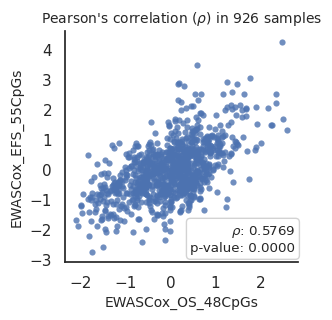

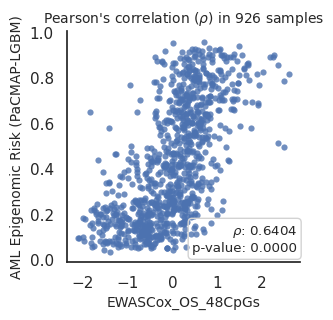

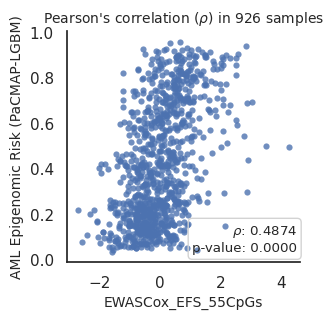

,EWASCox_OS_48CpGs,EWASCox_EFS_55CpGs,AML Epigenomic Risk (PaCMAP-LGBM),Risk Group AAML1831,Risk Group
EWASCox_OS_48CpGs,1.00,0.58,0.64,0.48,0.52
EWASCox_EFS_55CpGs,0.58,1.00,0.49,0.36,0.35
AML Epigenomic Risk (PaCMAP-LGBM),0.64,0.49,1.00,0.48,0.50
Risk Group AAML1831,0.48,0.36,0.48,1.00,0.63
Risk Group,0.52,0.35,0.50,0.63,1.00


In [5]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt


def draw_scatterplot(df,x,y,s):

    sns.set_theme(style="white")
    f, ax = plt.subplots(figsize=(3, 3))
    sns.despine(f, left=False, bottom=False)

    # Set font size for all elements
    sns.set_context("notebook", font_scale=0.8)

    # Define scatterplot

    sns.scatterplot(x=x, y=y,
                    palette='flare', s=s,
                    sizes=(1, 8), linewidth=0, alpha=0.8,
                    data=df, ax=ax)

    # Calculate Pearson’s correlation coefficient (r)
    # and its two-tailed p-value (p)

    r,p = stats.pearsonr(df[x],df[y])

    # Replace plt.annotate() with ax.text() for automatic placement within the plot
    ax.text(0.99, 0.03, fr'$\rho$: {r:.4f}'+f'\np-value: {p:.4f}',
        transform=ax.transAxes,
        horizontalalignment='right', verticalalignment='bottom',
        bbox={'boxstyle': 'round', 'facecolor': 'none', 'edgecolor': 'lightgray' })

    # Define plot specs

    plt.xlabel(x, fontsize = 10)
    plt.ylabel(y, fontsize = 10)
    plt.title(r"Pearson's correlation ($\rho$) in " + str(len(df)) + " samples",
               fontsize = 10) 

    return(plt.show())

draw_scatterplot(df=df_cont_risk,x='EWASCox_OS_48CpGs', y='EWASCox_EFS_55CpGs',s=20)
draw_scatterplot(df=df_cont_risk,x='EWASCox_OS_48CpGs', y='AML Epigenomic Risk (PaCMAP-LGBM)',s=20)
draw_scatterplot(df=df_cont_risk,x='EWASCox_EFS_55CpGs', y='AML Epigenomic Risk (PaCMAP-LGBM)',s=20)

df_cont_risk.iloc[:,1:].corr().round(2)

## ROC-AUC comparison in independent validation cohort (AML02,08)

In [21]:
path_os_test = output_path + 'multivariate_cox_lasso/ewas_cog_os_48CpGs_test.xlsx'
path_efs_test = output_path + 'multivariate_cox_lasso/ewas_cog_efs_55CpGs_test.xlsx'

ewas_cox_OS_48CpGs_test = pd.read_excel(path_os_test, index_col=0)[['EWASCox_OS_48CpGs','EWASCox_OS_48CpGs_cat_bin']]
ewas_cox_EFS_55CpGs_test = pd.read_excel(path_efs_test, index_col=0)[['EWASCox_EFS_55CpGs','EWASCox_EFS_55CpGs_cat_bin']]

ewas_cox_OS_48CpGs_test = ewas_cox_OS_48CpGs_test.rename(columns={'EWASCox_OS_48CpGs':'EWASCox_OS_48CpGs (cont)'}).rename(columns={'EWASCox_OS_48CpGs_cat_bin':'EWASCox_OS_48CpGs'})
ewas_cox_EFS_55CpGs_test = ewas_cox_EFS_55CpGs_test.rename(columns={'EWASCox_EFS_55CpGs':'EWASCox_EFS_55CpGs (cont)'}).rename(columns={'EWASCox_EFS_55CpGs_cat_bin':'EWASCox_EFS_55CpGs'})

df_combined_test = df_test.join(ewas_cox_OS_48CpGs_test).join(ewas_cox_EFS_55CpGs_test)

df_cat = df_combined_test[['os.evnt', 'EWASCox_OS_48CpGs', 'EWASCox_EFS_55CpGs', 'AML Epigenomic Risk_int']]
df_cont = df_combined_test[['os.evnt', 'EWASCox_OS_48CpGs (cont)', 'EWASCox_EFS_55CpGs (cont)', 'P(Death)']]

df_cont = df_cont.rename(columns={'P(Death)':'AML Epigenomic Risk (PaCMAP-LGBM)',
                                  'EWASCox_OS_48CpGs (cont)': 'EWASCox_OS_48CpGs',
                                  'EWASCox_EFS_55CpGs (cont)': 'EWASCox_EFS_55CpGs'})

df_cat = df_cat.rename(columns={'AML Epigenomic Risk':'AML Epigenomic Risk (PaCMAP-LGBM)'})
risk = df_test[['Risk Group']]

low_high_dict = {'Low': 0, 'Low Risk': 0,
                'Standard':0.5, 'Standard Risk': 0.5,
                'High': 1, 'High Risk': 1}

risk['Risk Group'] = risk['Risk Group'].map(low_high_dict)

df_cont_risk = df_cont.join(risk)
df_cat_risk = df_cat.join(risk)

df_cont_risk = df_cont_risk.dropna()
df_cat_risk = df_cat_risk.dropna()

# Rename `Risk Group` to `Risk Group AML02,08`
df_cont_risk = df_cont_risk.rename(columns={'Risk Group':'Risk Group AML02-08'})
df_cat_risk = df_cat_risk.rename(columns={'Risk Group':'Risk Group AML02-08'})

p1 = plot_roc_auc(df_cont_risk, 'os.evnt',title= 'Continuous (prob. of high risk)', color_option='colors1')
p2 = plot_roc_auc(df_cat_risk, 'os.evnt',title= 'Categorical (high-low risk)', color_option='colors1')

# Create a gridplot
p = gridplot([[p1, p2]], toolbar_location='above')

show(p)

## Correlation of continuous Px models in validation (AML02,08)

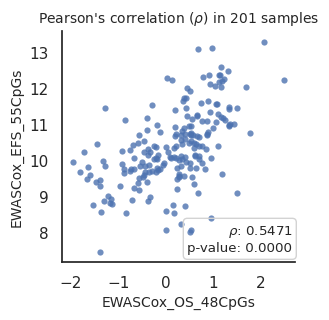

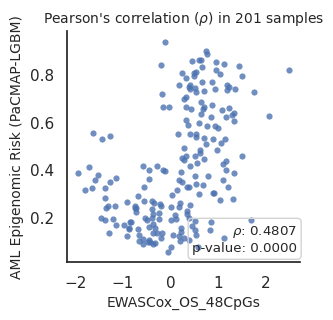

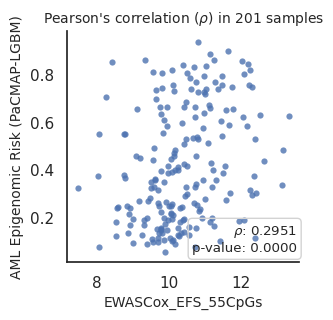

,EWASCox_OS_48CpGs,EWASCox_EFS_55CpGs,AML Epigenomic Risk (PaCMAP-LGBM),Risk Group AML02-08
EWASCox_OS_48CpGs,1.00,0.55,0.48,0.44
EWASCox_EFS_55CpGs,0.55,1.00,0.30,0.14
AML Epigenomic Risk (PaCMAP-LGBM),0.48,0.30,1.00,0.35
Risk Group AML02-08,0.44,0.14,0.35,1.00


In [22]:
draw_scatterplot(df=df_cont_risk,x='EWASCox_OS_48CpGs', y='EWASCox_EFS_55CpGs',s=20)
draw_scatterplot(df=df_cont_risk,x='EWASCox_OS_48CpGs', y='AML Epigenomic Risk (PaCMAP-LGBM)',s=20)
draw_scatterplot(df=df_cont_risk,x='EWASCox_EFS_55CpGs', y='AML Epigenomic Risk (PaCMAP-LGBM)',s=20)

df_cont_risk.iloc[:,1:].corr().round(2)